In [29]:
from concurrent.futures import ThreadPoolExecutor
import csv
from glob import glob
import math
from subprocess import check_output as run_program, CalledProcessError, TimeoutExpired
import re
import random

GENERATED_PAT = re.compile('% Final active clauses: ([0-9]+)')
AWRS = ["8:1","5:1","4:1","3:1","2:1","3:2","5:4","1","2:3","2","3","4","5","6","7","8","10","12","14","16","20","24","28","32","40","50","64","128","1024"]
EXECUTOR = ThreadPoolExecutor(4)
STEP = 0.05
MIN = -10
MAX = 3
DENOMINATOR = 1024

def vampire(problem, awr):
    try:
        output = run_program([
            'vampire',
            '-t', '1',
            '--saturation_algorithm', 'discount',
            '--statistics', 'full',
            '--proof', 'off',
            '--age_weight_ratio', awr,
            problem
        ], timeout=1).decode('ascii')
        found = GENERATED_PAT.search(output, re.MULTILINE)
        if found is None:
            return float('nan')

        return int(found.group(1))
    except CalledProcessError:
        return float('nan')
    except TimeoutExpired:
        return float('nan')

def vampire_awrs(problem):
    return list(EXECUTOR.map(lambda awr: vampire(problem, awr), AWRS))

def all_problems():
    problems = [path for path in glob('Problems/**/*.p') if not '^' in path]
    random.seed(0)
    random.shuffle(problems)
    return problems

def awr_stats():
    for path in all_problems():
        result = vampire_awrs(path)
        problem = path.split('/')[-1]
        if any(not math.isnan(stat) for stat in result):
            yield [problem] + result

def create_data_file():
    with open('fixed-awr.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Problem'] + AWRS)
        for row in awr_stats():
            writer.writerow(row)
            f.flush()
            
def log_to_awr(x):
    linear = 2.0 ** x
    age = int(DENOMINATOR * linear)
    weight = DENOMINATOR
    return f"{age}:{weight}"

100%|██████████| 260/260 [00:18<00:00, 14.29it/s]


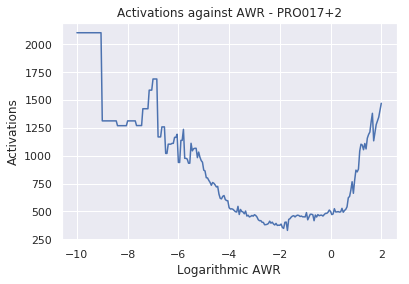

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set()

logarithmic = np.arange(MIN, MAX, STEP)
ratios = [log_to_awr(x) for x in logarithmic]
problem = 'Problems/PRO/PRO017+2.p'
active = list(tqdm(EXECUTOR.map(lambda ratio: vampire(problem, ratio), ratios), total=len(ratios)))
data = pd.DataFrame({
    "Logarithmic AWR": logarithmic,
    "Activations": active
})

sns.lineplot(data=data, x="Logarithmic AWR", y="Activations")
plt.title(f"Activations against AWR - PRO017+2")
plt.savefig('example-optimal-awr.pdf', bbox_inches='tight')